### !!! Run this on Prositserver unless you want to fry your desktop computer !!!

In [91]:
import sys
sys.path.append('../')

import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['axes.prop_cycle'] = plt.cycler("color", plt.cm.tab20c.colors)

from bin.qc.protein_qc_cvs import density_scatter, plotDensityScatterTrendLine
from bin import config
from bin import sample_metadata
from bin import sample_annotation
from bin import preprocess_tools

In [5]:
folder = '2023.06.22_CJ_batch114_w_replicates'
results_folder = f'/media/kusterlab/internal_projects/active/TOPAS/WP31/Playground/Retrospective_study/{folder}'

In [45]:
configs = config.load(f'{results_folder}/configs.json')
sample_annotation_df = sample_annotation.load_sample_annotation(configs["sample_annotation"])

In [57]:
qc_annotation_df = sample_annotation_df[['Cohort', 'Batch Name']].drop_duplicates()
qc_annotation_df['TMT Channel'] = [[9, 10, 11]]*len(qc_annotation_df.index)
qc_annotation_df = qc_annotation_df.explode('TMT Channel')
qc_annotation_df['Sample name'] = "QC-channel" + qc_annotation_df['TMT Channel'].astype(str).str.zfill(2) + "-" + qc_annotation_df['Cohort'] + "-Batch" + qc_annotation_df['Batch Name'].astype(str)
qc_annotation_df.head()

,Cohort,Batch Name,TMT Channel,Sample name
0,Sarcoma,1,9,QC-channel09-Sarcoma-Batch1
0,Sarcoma,1,10,QC-channel10-Sarcoma-Batch1
0,Sarcoma,1,11,QC-channel11-Sarcoma-Batch1
8,Sarcoma,2,9,QC-channel09-Sarcoma-Batch2
8,Sarcoma,2,10,QC-channel10-Sarcoma-Batch2


In [58]:
channel_to_sample_id_dict = sample_annotation.get_channel_to_sample_id_dict(sample_annotation_df, remove_replicates=False, remove_qc_failed=True)
channel_to_sample_id_dict |= sample_annotation.get_channel_to_sample_id_dict(qc_annotation_df, remove_replicates=False, remove_qc_failed=True)

In [9]:
fp_df = pd.read_csv(f'{results_folder}/preprocessed_fp2.csv', index_col='Gene names')
fp_df.head()

,Protein IDs,Majority protein IDs,Peptide counts (unique),Protein names,Fasta headers,Best peptide,Number of proteins,Q-value,Score,Unique peptides Reporter intensity corrected 1 Chordoma_Batch62,...,Identification metadata 9 Sarcoma_Batch9,Identification metadata 9 Sarcoma_Batch90,Identification metadata 9 Sarcoma_Batch91,Identification metadata 9 Sarcoma_Batch93,Identification metadata 9 Sarcoma_Batch94,Identification metadata 9 Sarcoma_Batch95,Identification metadata 9 Sarcoma_Batch96,Identification metadata 9 Sarcoma_Batch97,Identification metadata 9 Sarcoma_Batch98,Identification metadata 9 Sarcoma_Batch99
Gene names,,,,,,,,,,,,,,,,,,,,,
PLEC,PLEC,PLEC,3544,Plectin (Fragment),tr|E9PIA2|E9PIA2_HUMAN Plectin (Fragment) OS=H...,NaN,1,0.000092,220.364345,309,...,num_peptides=329;,num_peptides=312;,num_peptides=308;,num_peptides=342;,num_peptides=341;,num_peptides=322;,num_peptides=340;,num_peptides=347;,num_peptides=342;,num_peptides=329;
SPARCL1,SPARCL1,SPARCL1,73,SPARC-like protein 1 (Fragment),tr|F5H4Y3|F5H4Y3_HUMAN SPARC-like protein 1 (F...,NaN,1,0.000092,197.251223,1,...,num_peptides=5;,detected in batch;,NaN,detected in batch;,num_peptides=3;,detected in batch;,num_peptides=1;,num_peptides=4;,detected in batch;,detected in batch;
CKAP4,CKAP4,CKAP4,42,Cytoskeleton-associated protein 4 (Fragment),tr|F8VVU0|F8VVU0_HUMAN Cytoskeleton-associated...,NaN,1,0.000092,183.889309,40,...,num_peptides=45;,num_peptides=35;,num_peptides=40;,num_peptides=43;,num_peptides=43;,num_peptides=39;,num_peptides=40;,num_peptides=40;,num_peptides=43;,num_peptides=45;
SPTBN1,SPTBN1,SPTBN1,619,Spectrin beta chain,tr|A0A087WUZ3|A0A087WUZ3_HUMAN Spectrin beta c...,NaN,1,0.000092,181.972447,154,...,num_peptides=156;,num_peptides=116;,num_peptides=122;,num_peptides=139;,num_peptides=141;,num_peptides=148;,num_peptides=156;,num_peptides=155;,num_peptides=163;,num_peptides=145;
TMED10,TMED10,TMED10,12,Transmembrane emp24 domain-containing protein 10,tr|G3V2K7|G3V2K7_HUMAN Transmembrane emp24 dom...,NaN,1,0.000092,170.668593,11,...,num_peptides=13;,num_peptides=11;,num_peptides=11;,num_peptides=11;,num_peptides=14;,num_peptides=11;,num_peptides=12;,num_peptides=12;,num_peptides=11;,num_peptides=10;


In [60]:
fp_df_sample_names = preprocess_tools.rename_columns_with_sample_ids(fp_df.reset_index(), channel_to_sample_id_dict, index_cols=['Gene names'], remove_ref=True)

In [100]:
def plot_CVs(df, xlim, label, min_observed=None, input_is_log10=True):
    if input_is_log10:
        df = np.power(10, df)
    
    if min_observed is None or min_observed > df.shape[1]:
        df = df.dropna()
    else:
        df = df[df.count(axis=1) >= min_observed] # at least 10 channels are filled
            
    cv = df.std(axis=1) / df.mean(axis=1)
    n_samples = len(df.columns)
    n_features = len(df.index)
    # print(cv.head(n=20))
    
    df = df.apply(np.log10)
    df['Median intensity'] = df.median(axis=1)
    df['CV'] = cv
    df = df[~df['Median intensity'].isna()]
    df = df[~df['CV'].isna()]

    # plt.figure(1)
    
    # ax = density_scatter(np.array(df['Median intensity']), np.array(df['CV']), bins=100, s=1)
    # plotDensityScatterTrendLine(np.array(df['Median intensity']), np.array(df['CV']), ax, numBins = 20)
    # ax.set_xlabel('log10(intensity)')
    # ax.set_ylabel('CV')
    
    # ax.plot(xlim, [0.2, 0.2], '--')
    # plt.tight_layout()
    # plt.xlim(xlim)
    # plt.ylim([0,1.5])

    plt.figure(2)
    plt.hist(df['CV']*100, cumulative=True, bins=np.linspace(0,100.1,1000), histtype='step', density=True, label=f"{label} (n_samples={n_samples}, n_features={n_features})")
    plt.xlim([0, 100])
    plt.xlabel('% CV')
    plt.ylabel('Cumulative frequency')


In [84]:
triplicate_samples = {
    "I028-003-84352": "P0231",
    "I137-003-84050": "P0232",
    "I011-005-226590": "P0291",
    "I002-025-226610": "P0292",
    "I036-057-226650": "P0293",
    "I054-033-226658": "P0294",
    "I054-034-226668": "P0295",
    "H021-UBLX5J-T4-E2": "P0326",
}
qc_samples = ["QC-channel09", "QC-channel10", "QC-channel11"]
batch_ranges = {
    #'all': range(1, 115), # all QC
    'batch_001-072': range(1, 72), # old QC, up to batch 71
    'batch_073-115': range(73, 115) # new QC, from batch 73
}

In [ ]:
def filter_batch_numbers(column_names, valid_batch_numbers):
    return [c for c in column_names if int(re.search(r'Batch(\d{1,3})', c).group(1)) in valid_batch_numbers]

In [64]:
xlim = [5,10]
min_observed_threshold = 0.7 # minimum fraction of samples gene / p-site has to be present in to include in CV plot

In [105]:
def plot_CVs_replicates_and_QC(df_with_sample_names, triplicate_samples, batch_ranges, label, min_observed_threshold = 0.7, xlim = [5,10]):
    """_summary_

    Args:
        df_with_sample_names (_type_): _description_
        triplicate_samples (_type_): _description_
        batch_ranges (_type_): _description_
        label (_type_): _description_
        min_observed_threshold (float, optional): minimum fraction of samples gene / p-site has to be present in to include in CV plot. Defaults to 0.7.
        xlim (list, optional): _description_. Defaults to [5,10].
    """    
    for sample_name, pseudonym in triplicate_samples.items():
        sample_replicate_df = df_with_sample_names.filter(regex=f'^{sample_name}')    
        plot_CVs(sample_replicate_df, xlim, label=pseudonym)

    for batch_range_label, batch_range in batch_ranges.items():
        for sample_name in qc_samples:
            sample_replicate_df = df_with_sample_names.filter(regex=f'^{sample_name}')
            sample_replicate_df = sample_replicate_df.loc[:, filter_batch_numbers(sample_replicate_df.columns, batch_range)] 
            plot_CVs(sample_replicate_df, xlim, label=f"{sample_name} {batch_range_label}", min_observed=min_observed_threshold*len(sample_replicate_df.columns))

    legend = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.savefig(f'{results_folder}/{label}_replicate+QC_CVs.svg', bbox_extra_artists=(legend,), bbox_inches='tight')

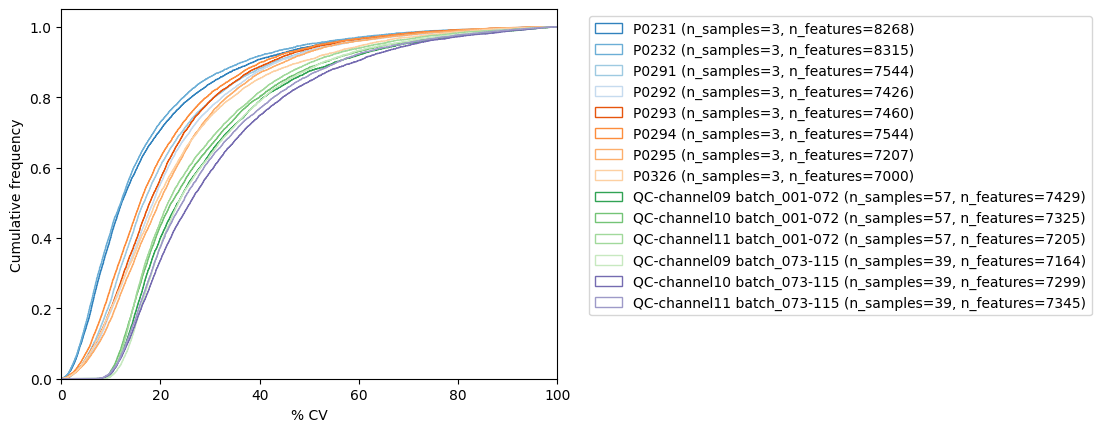

In [106]:
plot_CVs_replicates_and_QC(fp_df_sample_names, triplicate_samples, batch_ranges, 'FP', min_observed_threshold, xlim)

In [18]:
pp_df = pd.read_csv(f'{results_folder}/preprocessed_pp2.csv', index_col='Modified sequence')
pp_df.head()

/tmp/ipykernel_3311391/2237835736.py:1: DtypeWarning: Columns (12,13,14,15,16,17,18,19,34,35,36,37,38,39,40,41,56,57,58,59,60,61,62,63,78,79,80,81,82,83,84,85,100,101,102,103,104,105,106,107,122,123,124,125,126,127,128,129,144,145,146,147,148,149,150,151,166,167,168,169,170,171,172,173,188,189,190,191,192,193,194,195,210,211,212,213,214,215,216,217,232,233,234,235,236,237,238,239,254,255,256,257,258,259,260,261,276,277,278,279,280,281,282,283,298,299,300,301,302,303,304,305,320,321,322,323,324,325,326,327,342,343,344,345,346,347,348,349,364,365,366,367,368,369,370,371,386,387,388,389,390,391,392,393,408,409,410,411,412,413,414,415,430,431,432,433,434,435,436,437,452,453,454,455,456,457,458,459,474,475,476,477,478,479,480,481,496,497,498,499,500,501,502,503,518,519,520,521,522,523,524,525,540,541,542,543,544,545,546,547,562,563,564,565,566,567,568,569,584,585,586,587,588,589,590,591,606,607,608,609,610,611,612,613,628,629,630,631,632,633,634,635,650,651,652,653,654,655,656,657,672,673,6

,Reporter intensity corrected 1 Chordoma_Batch62,Reporter intensity corrected 2 Chordoma_Batch62,Reporter intensity corrected 3 Chordoma_Batch62,Reporter intensity corrected 4 Chordoma_Batch62,Reporter intensity corrected 5 Chordoma_Batch62,Reporter intensity corrected 6 Chordoma_Batch62,Reporter intensity corrected 7 Chordoma_Batch62,Reporter intensity corrected 8 Chordoma_Batch62,Reporter intensity corrected 9 Chordoma_Batch62,Reporter intensity corrected 10 Chordoma_Batch62,...,Identification metadata 4 Sarcoma_Batch99,Identification metadata 5 Sarcoma_Batch99,Identification metadata 6 Sarcoma_Batch99,Identification metadata 7 Sarcoma_Batch99,Identification metadata 8 Sarcoma_Batch99,Identification metadata 9 Sarcoma_Batch99,Identification metadata 10 Sarcoma_Batch99,Identification metadata 11 Sarcoma_Batch99,Gene names,Proteins
Modified sequence,,,,,,,,,,,,,,,,,,,,,
_(Acetyl (Protein N-term))AAAAPDSRVpSEEENLKK_,5.526780,5.443639,5.874708,6.344160,5.857692,5.931069,5.552249,6.144687,6.133297,7.367295,...,NaN,partially imputed;,NaN,NaN,NaN,NaN,NaN,NaN,RRP15,Q9Y3B9
_(Acetyl (Protein N-term))AAASVTPPGpSLELLQPGFSK_,5.427966,5.761893,6.351051,5.652124,5.864970,4.934247,5.650278,4.351051,4.907589,5.183512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAF2,B1AMX7;B1AMX8;B1AMY1;Q12933;Q12933-2;Q12933-3;...
_(Acetyl (Protein N-term))AAAVAAAGAGEPQpSPDELLPK_,6.758366,6.317973,6.775204,6.335410,6.283473,6.473536,6.409284,6.313636,5.798782,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TOMM22,Q9NS69
_(Acetyl (Protein N-term))AAApSVTPPGSLELLQPGFSK_,6.280803,6.239753,6.416675,6.464200,6.248878,6.449859,6.242236,6.004737,6.342399,6.497856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TRAF2,B1AMX7;B1AMX8;B1AMY1;Q12933;Q12933-2;Q12933-3;...
_(Acetyl (Protein N-term))AADVSVTHRPPLpSPK_,7.462769,7.797418,7.682687,7.785097,7.600225,7.576100,7.542753,7.713002,8.070443,8.010941,...,NaN,partially imputed;,NaN,NaN,NaN,NaN,NaN,NaN,RAVER1,A0A087WZ13;Q8IY67;Q8IY67-2;Q8IY67-3


In [70]:
pp_df_sample_names = preprocess_tools.rename_columns_with_sample_ids(pp_df.reset_index(), channel_to_sample_id_dict, index_cols=['Modified sequence'], remove_ref=True)

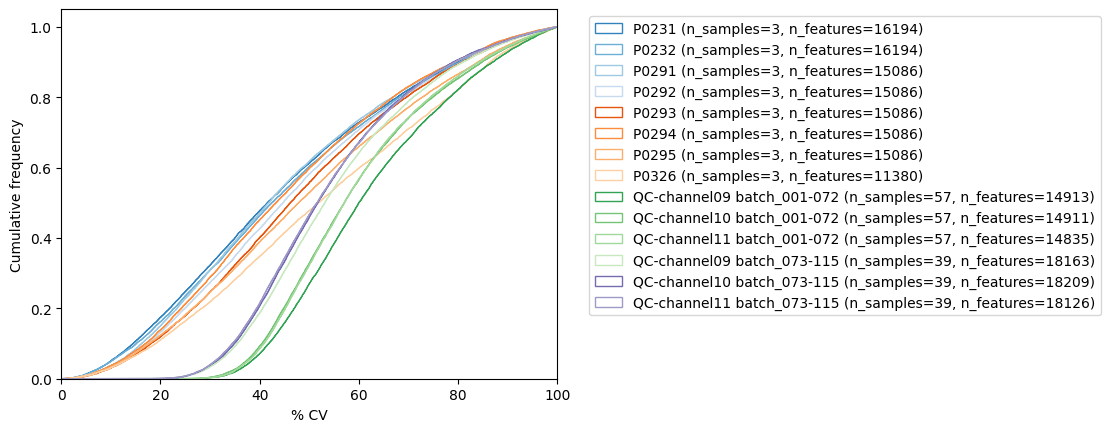

In [107]:
plot_CVs_replicates_and_QC(pp_df_sample_names, triplicate_samples, batch_ranges, 'PP', min_observed_threshold, xlim)

In [37]:
pp_gene_level_df = pp_df.set_index('Gene names').filter(like='Reporter intensity corrected').copy()

In [38]:
pp_gene_level_df = np.power(10, pp_gene_level_df)

In [39]:
pp_gene_level_grouped_df = pp_gene_level_df.groupby('Gene names').agg(sum)
pp_gene_level_grouped_df = np.log10(pp_gene_level_grouped_df)
pp_gene_level_grouped_df = pp_gene_level_grouped_df.replace(-np.inf, np.nan)
pp_gene_level_grouped_df.head()

/home/matthewt/.cache/pypoetry/virtualenvs/wp3-sample-pipeline-OkE4pj9k-py3.9/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


,Reporter intensity corrected 1 Chordoma_Batch62,Reporter intensity corrected 2 Chordoma_Batch62,Reporter intensity corrected 3 Chordoma_Batch62,Reporter intensity corrected 4 Chordoma_Batch62,Reporter intensity corrected 5 Chordoma_Batch62,Reporter intensity corrected 6 Chordoma_Batch62,Reporter intensity corrected 7 Chordoma_Batch62,Reporter intensity corrected 8 Chordoma_Batch62,Reporter intensity corrected 9 Chordoma_Batch62,Reporter intensity corrected 10 Chordoma_Batch62,...,Reporter intensity corrected 2 Sarcoma_Batch99,Reporter intensity corrected 3 Sarcoma_Batch99,Reporter intensity corrected 4 Sarcoma_Batch99,Reporter intensity corrected 5 Sarcoma_Batch99,Reporter intensity corrected 6 Sarcoma_Batch99,Reporter intensity corrected 7 Sarcoma_Batch99,Reporter intensity corrected 8 Sarcoma_Batch99,Reporter intensity corrected 9 Sarcoma_Batch99,Reporter intensity corrected 10 Sarcoma_Batch99,Reporter intensity corrected 11 Sarcoma_Batch99
Gene names,,,,,,,,,,,,,,,,,,,,,
A1BG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1CF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A2ML1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AAAS,7.73853,7.843598,7.806053,7.707522,7.644835,7.667236,7.714991,7.744993,8.048381,8.186098,...,8.110494,8.01609,8.121863,7.922412,7.604281,7.952479,7.785135,8.205758,8.146767,8.151313


In [75]:
pp_gene_level_df_sample_names = preprocess_tools.rename_columns_with_sample_ids(pp_gene_level_grouped_df.reset_index(), channel_to_sample_id_dict, index_cols=['Gene names'], remove_ref=True)

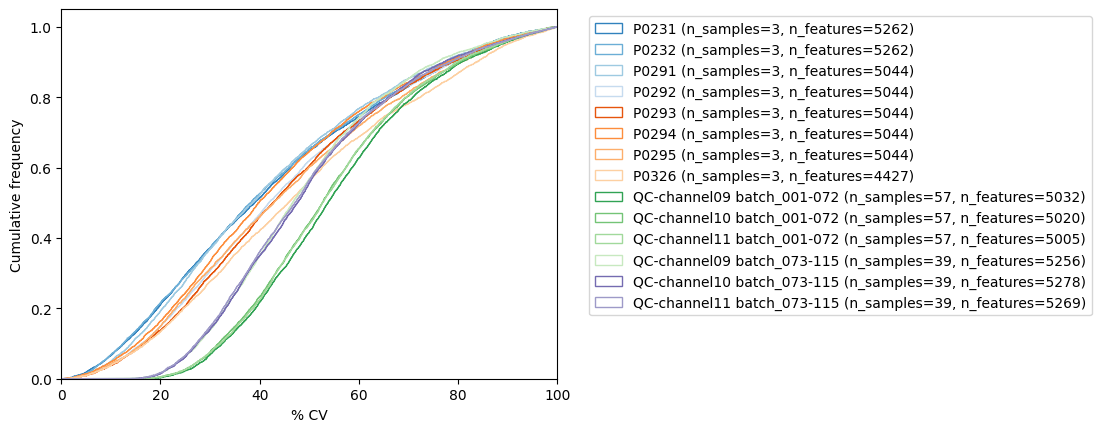

In [108]:
plot_CVs_replicates_and_QC(pp_gene_level_df_sample_names, triplicate_samples, batch_ranges, 'PP_gene_level', min_observed_threshold, xlim)